# testing enformer evaluation and creating a utils for it

In [9]:
#the first and most basic issue is that we can't directly import the yaml, as we need to evaluate it with hydra

from omegaconf import OmegaConf
import os
import yaml
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-08-04/18-50-28-774268/checkpoints/00-val_loss=0.66647.ckpt'
model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
with open(model_cfg_path) as f:
    model_cfg = yaml.load(f, Loader=yaml.FullLoader)
print(model_cfg)

{'train': {'seed': 2222, 'interval': 'epoch', 'monitor': 'val/loss', 'mode': 'min', 'ema': 0.0, 'test': False, 'debug': False, 'ignore_warnings': False, 'state': {'mode': None, 'n_context': 0, 'n_context_eval': '${.n_context}'}, 'ckpt': None, 'disable_dataset': False, 'validate_at_start': False, 'pretrained_model_path': None, 'pretrained_model_strict_load': False, 'pretrained_model_state_hook': {'_name_': 'load_backbone', 'freeze_backbone': False, 'ignore_head': True, 'add_embeddings': False, 'ignore_embeddings': False}, 'post_init_hook': {'_name_': None}, 'layer_decay': {'_name_': None, 'decay': 0.7}, 'gpu_mem': '${eval:"round(float(__import__(\'subprocess\').check_output(\'nvidia-smi -i 0 --query-gpu=memory.total --format=csv,noheader,nounits\', shell=True).strip().decode()) / 1000)"}', 'global_batch_size': '${dataset.batch_size}'}, 'tolerance': {'logdir': './resume', 'id': None}, 'wandb': {'project': 'dna', 'group': 'enformer', 'job_type': 'training', 'mode': 'online', 'name': 'enfo

In [16]:
cfg = OmegaConf.create(model_cfg)
OmegaConf.register_new_resolver('eval', eval)
OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
cfg_resolved = OmegaConf.to_container(cfg, resolve=True)


In [17]:
cfg_resolved

{'train': {'seed': 2222,
  'interval': 'epoch',
  'monitor': 'val/loss',
  'mode': 'min',
  'ema': 0.0,
  'test': False,
  'debug': False,
  'ignore_warnings': False,
  'state': {'mode': None, 'n_context': 0, 'n_context_eval': 0},
  'ckpt': None,
  'disable_dataset': False,
  'validate_at_start': False,
  'pretrained_model_path': None,
  'pretrained_model_strict_load': False,
  'pretrained_model_state_hook': {'_name_': 'load_backbone',
   'freeze_backbone': False,
   'ignore_head': True,
   'add_embeddings': False,
   'ignore_embeddings': False},
  'post_init_hook': {'_name_': None},
  'layer_decay': {'_name_': None, 'decay': 0.7},
  'gpu_mem': 46,
  'global_batch_size': 2},
 'tolerance': {'logdir': './resume', 'id': None},
 'wandb': {'project': 'dna',
  'group': 'enformer',
  'job_type': 'training',
  'mode': 'online',
  'name': 'enformer_cnn_kmer_1',
  'save_dir': '.',
  'id': 'enformer_cnn_kmer_1'},
 'trainer': {'_target_': 'pytorch_lightning.Trainer',
  'devices': 1,
  'accelerator

In [1]:
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import EnformerEncoder
import torch
import numpy as np
import src.dataloaders.datasets.enformer_dataset as enformer_dataset
import yaml
from omegaconf import OmegaConf
import os

OmegaConf.register_new_resolver('eval', eval)
OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)

class IdentityNet(torch.nn.Module):
    def __init__(self):
        super(IdentityNet, self).__init__()

    def forward(self, x):
        return x, None

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        state_dict = torch.load(ckpt_path, map_location='cpu')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
                                                            return_CAGE=dataset_args['return_cage'], cell_type=dataset_args.get('cell_type', None),
                                                            kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        self.cfg['decoder']['d_output'] = self.dataset.d_output     
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        self.backbone = DNAEmbeddingModel(**self.cfg['model'])
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        if encoder_state_dict: #if it's emtpy, means no encoder, so just use identity!
            del self.cfg['encoder']['_name_']
            self.encoder = EnformerEncoder(**self.cfg['encoder'])
            self.encoder.load_state_dict(encoder_state_dict, strict=True)
        else:
            self.encoder = IdentityNet()
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()


In [2]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-08-04/18-50-28-774268/checkpoints/00-val_loss=0.66647.ckpt'
evals = Evals(ckpt_path)

Using kmer genome with length 6


In [3]:
#let's load an example and pass it through
test_ex = evals.dataset[0][0].unsqueeze(0).to(evals.device)
test_ex.shape

torch.Size([1, 196608])

In [5]:
#now pass it through
with torch.no_grad():
    x,_ = evals.encoder(test_ex)
    x,_ = evals.backbone(x)
    x = evals.decoder(x)
    print(x.shape)

torch.Size([1, 896, 4675])


In [7]:
#ah that's perfect. 
x.nbytes*2000/1e9 #would be like 33 GB for all the data... could just have it in memory tho?
#basically is 4 million by 2000 is ends up being a lot of space
#not worth storing all the results, but we can still look at individual tracks

33.5104

# let's evaluate one of the models

In [1]:
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from evals.evals_utils_enformer import Evals
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-08-03/10-04-47-732912/checkpoints/03-val_loss=0.66222.ckpt'
evals = Evals(ckpt_path)

In [2]:
print(evals.device)

cuda


In [3]:
evals(idx=0)

tensor([[[0.0685, 0.0611, 0.0412,  ..., 0.3209, 0.3462, 0.2281],
         [0.1245, 0.1108, 0.0823,  ..., 0.4170, 0.4668, 0.2459],
         [0.1111, 0.0989, 0.0715,  ..., 0.3781, 0.4232, 0.2479],
         ...,
         [0.0787, 0.0781, 0.0677,  ..., 0.9229, 1.0218, 0.3856],
         [0.0971, 0.0840, 0.0737,  ..., 2.0869, 2.3804, 0.7594],
         [0.0926, 0.0726, 0.0661,  ..., 1.5482, 1.7886, 0.5877]]],
       device='cuda:0')

In [5]:
#and let's plot example 1
import matplotlib.pyplot as plt
import numpy as np

out2 = evals(idx=1)
y = evals.dataset[1][1].numpy()

Text(0.5, 1.0, 'convolutions model')

Error in callback <function flush_figures at 0x2b8637eaa020> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Text(0.5, 1.0, 'convolutions model')

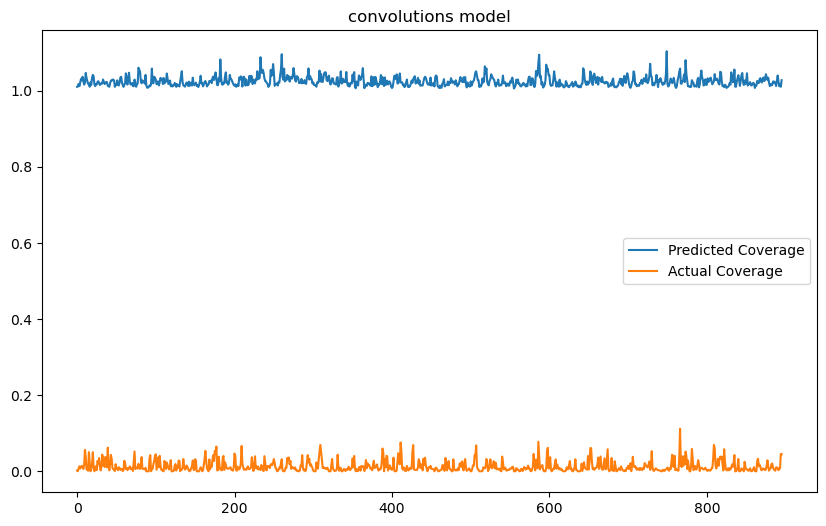

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[0,:, 121].cpu()), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')
#and add legend
plt.legend()
plt.title('convolutions model')

#this is stragiht up just noise, no?

In [7]:
y.shape

(896, 4675)

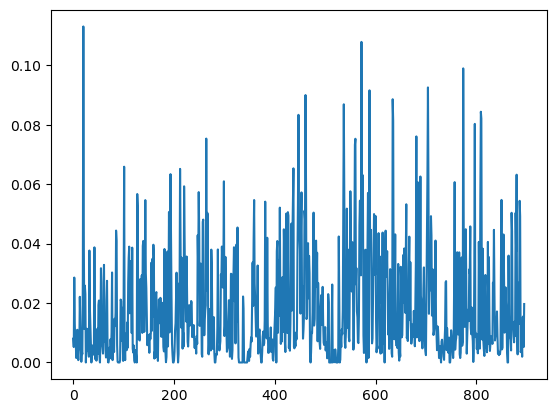

In [11]:
plt.plot(evals.dataset[0][1][:,121]) #this is the 0 example is noise

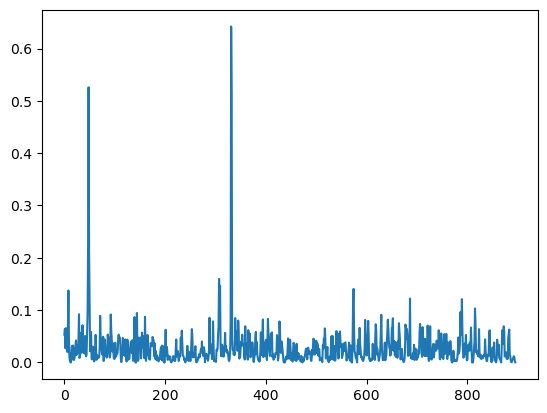

In [12]:
plt.plot(evals.dataset[2][1][:,121]) #this one is less noise

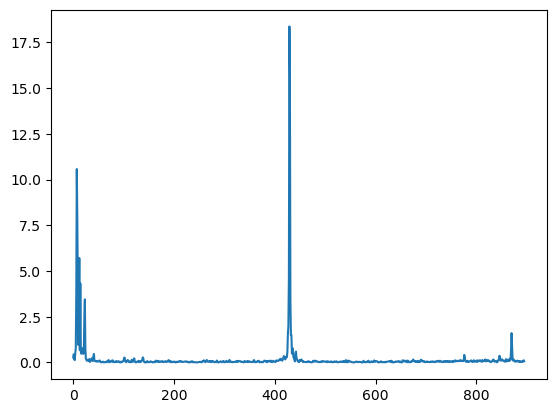

In [13]:
plt.plot(evals.dataset[3][1][:,121]) #this is a good peak to look at!

Text(0.5, 1.0, 'hyena model')

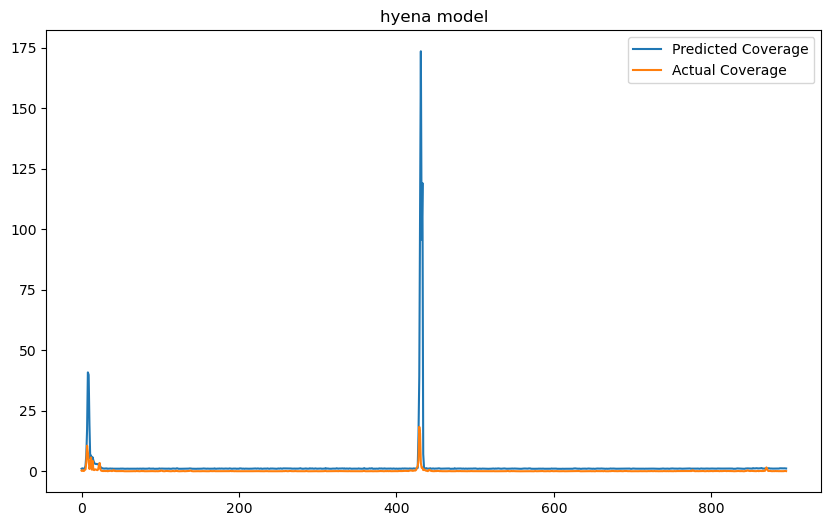

In [14]:
out2 = evals(idx=3)
y = evals.dataset[3][1].numpy()

plt.figure(figsize=(10, 6))
plt.plot(np.exp(out2[0,:, 121].cpu()), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')
#and add legend
plt.legend()
plt.title('hyena model')

Text(0.5, 1.0, 'hyena model')

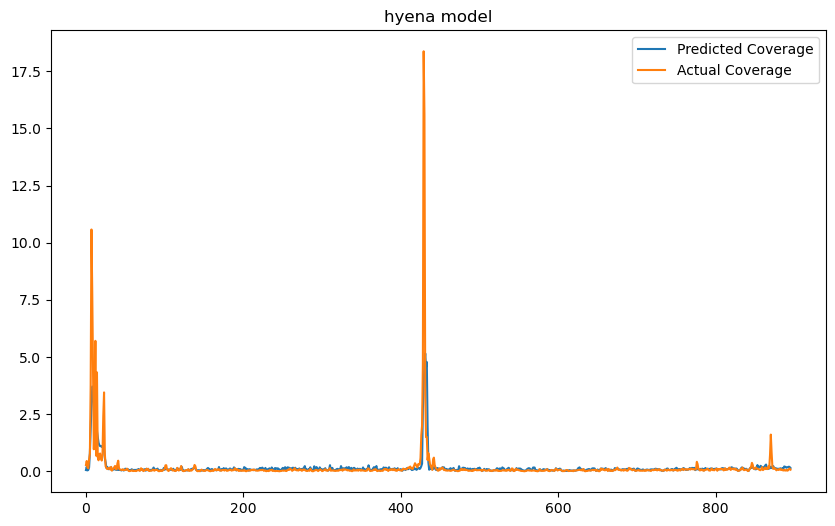

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(out2[0,:, 121].cpu(), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')
#and add legend
plt.legend()
plt.title('hyena model')

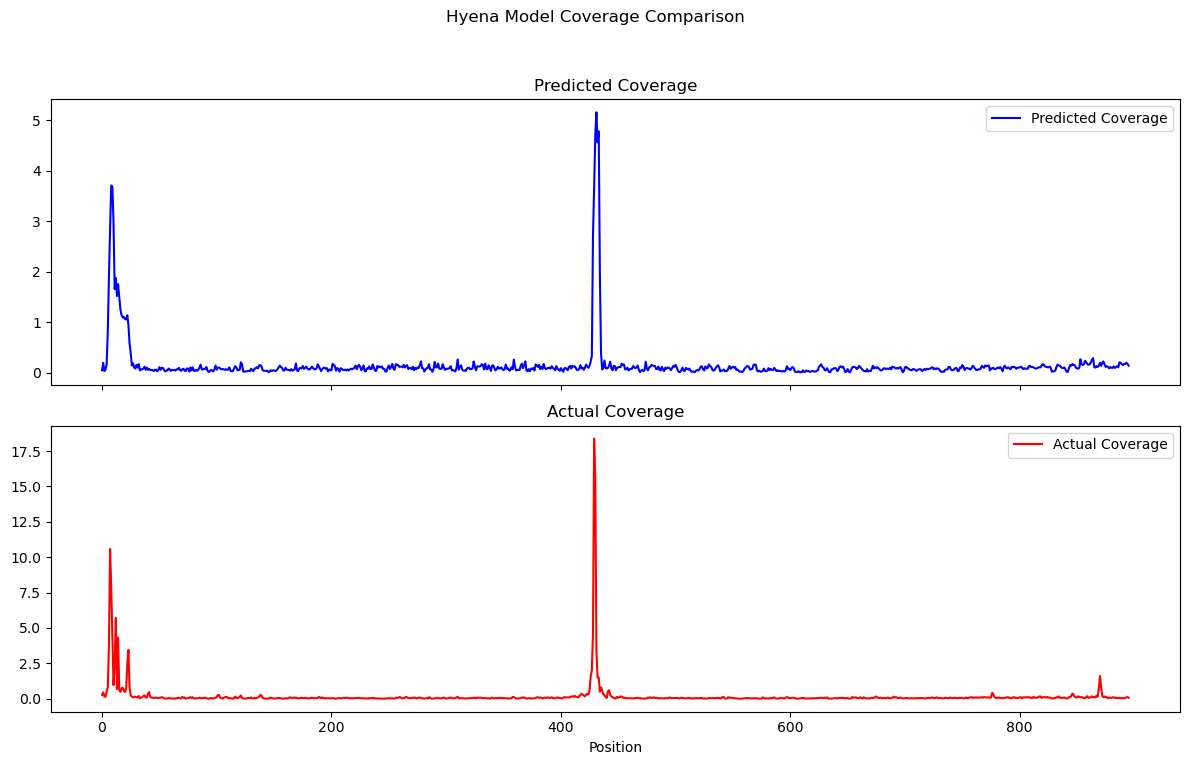

In [17]:
#should ideally be using the exponential, maybe it just hasn't learned enough? we do softplus with 
#wait no we shouldnl't be using the exponential! As it is the softplus which means predicting the counts directly!
#so that means don't do any exponential when we are plotting it!
#so this seems to do an ok job

import matplotlib.pyplot as plt

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the predicted coverage on the first subplot
ax1.plot(out2[0, :, 121].cpu(), label='Predicted Coverage', color='b')
ax1.set_title('Predicted Coverage')
ax1.legend()

# Plot the actual coverage on the second subplot
ax2.plot(y[:, 121], label='Actual Coverage', color='r')
ax2.set_title('Actual Coverage')
ax2.legend()

# Add a shared x-axis label
ax2.set_xlabel('Position')

# Add a common y-axis label for both plots
# fig.text(0.04, 0.5, 'Coverage', va='center', rotation='vertical')

# Add a common title for both plots
fig.suptitle('Hyena Model Coverage Comparison')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


# enformer evaluation

In [1]:
#and seeing how enformer does

split = 'test'
max_length = 196608
idx = 3

chrom_info= {'chr1': [10000, 248946422],
 'chr2': [10000, 242183529],
 'chr3': [10000, 198235559],
 'chr4': [10000, 190204555],
 'chr5': [10000, 181478259],
 'chr6': [60000, 170745979],
 'chr7': [10000, 159335973],
 'chr8': [60000, 145078636],
 'chr9': [10000, 138334717],
 'chr10': [10000, 133787422],
 'chr11': [60000, 135076622],
 'chr12': [10000, 133265309],
 'chr13': [16000000, 114354328],
 'chr14': [16022637, 106883718],
 'chr15': [17000000, 101981189],
 'chr16': [10000, 90228345],
 'chr17': [60000, 83247441],
 'chr18': [10000, 80263285],
 'chr19': [60000, 58607616],
 'chr20': [60000, 64334167],
 'chr21': [5010000, 46699983],
 'chr22': [10510000, 50808468],
 'chrX': [10000, 156030895],
 'chrY': [2781479, 56887902],}

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
enformer_model = hub.load("https://kaggle.com/models/deepmind/enformer/frameworks/TensorFlow2/variations/enformer/versions/1").model

SEQ_LENGTH = 393_216
import zarr
import numpy as np
genome_np = '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz'
with np.load(genome_np) as data:
    genome = {key: np.array(data[key]) for key in data}

seqs = pd.read_csv('/data/leslie/sarthak/data/enformer/data/human/sequences.bed', sep='\t', header=None)
seqs_bed = seqs[seqs[3] == split]
seq = np.zeros((len(seqs_bed), max_length), dtype=genome['chr1'].dtype) #note with 16 bit it takes a lo;t of space, can migrate to not preallocating, just get when we need it
length = 131072 #the length of the sequences form enformer
seqs_np = seqs_bed.to_numpy()

data_path = f'/data/leslie/sarthak/data/enformer/data/{split}_label.zarr'
labels = zarr.open(data_path, mode='r')['labels']

row = seqs_np[idx]
chrom = row[0]
start = row[1]
end = row[2]
diff = (max_length - length)//2 #note this works even if we want a shorter length!
start = start - diff
end = end + diff
leftpad = np.zeros(0)
rightpad = np.zeros(0)
if start < 0:
    leftpad = np.ones(-start)*11
    start = 0
chromlen = chrom_info[chrom][1]
if end > chromlen:
    rightpad = np.ones(end-chromlen)*11
    end = chromlen
seq = np.concatenate([leftpad, genome[chrom][start:end], rightpad])

targets = labels[idx]
# print(counts)
targets = targets[:, :4675]


2024-08-05 13:39:44.239455: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-08-05 13:40:11.054477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-08-05 13:40:11.249488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.35GiB deviceMemoryBandwidth: 648.29GiB/s
2024-08-05 13:40:11.251694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.35GiB deviceMemoryBandwidth: 648.29GiB/s
2024-08-05 13:40:11.256886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:ca:00.0 name: NVIDIA A40 com

In [2]:
print(targets.shape)
print(seq.shape)

(896, 4675)
(196608,)


In [3]:
def ohe(data):
    out = np.zeros((data.shape[0],4))
    for i,nuc in enumerate(data):
        if nuc == 7:
            out[i] = np.array([1,0,0,0])
        elif nuc == 8:
            out[i] = np.array([0,1,0,0])
        elif nuc == 9:
            out[i] = np.array([0,0,1,0])
        elif nuc == 10:
            out[i] = np.array([0,0,0,1])
        else:
            out[i] = np.array([0,0,0,0])
    padding_size = (SEQ_LENGTH - out.shape[0]) // 2
    padded_array = np.pad(out, ((padding_size, padding_size), (0, 0)), mode='constant', constant_values=0)
    return padded_array[np.newaxis, ...]
x = ohe(seq)

In [5]:
y_pred = enformer_model.predict_on_batch(x)['human'][0]
print(y_pred.shape)

2024-08-05 13:41:57.407889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-08-05 13:41:57.521549: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200000000 Hz
2024-08-05 13:41:58.273634: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-08-05 13:42:00.335009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-08-05 13:42:00.335435: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-05 13:42:00.347599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-08-05 13:42:00.503977: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8907


(896, 5313)


In [6]:
print(x.shape)
print(y_pred.shape)
print(targets.shape)

(1, 393216, 4)
(896, 5313)
(896, 4675)


Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


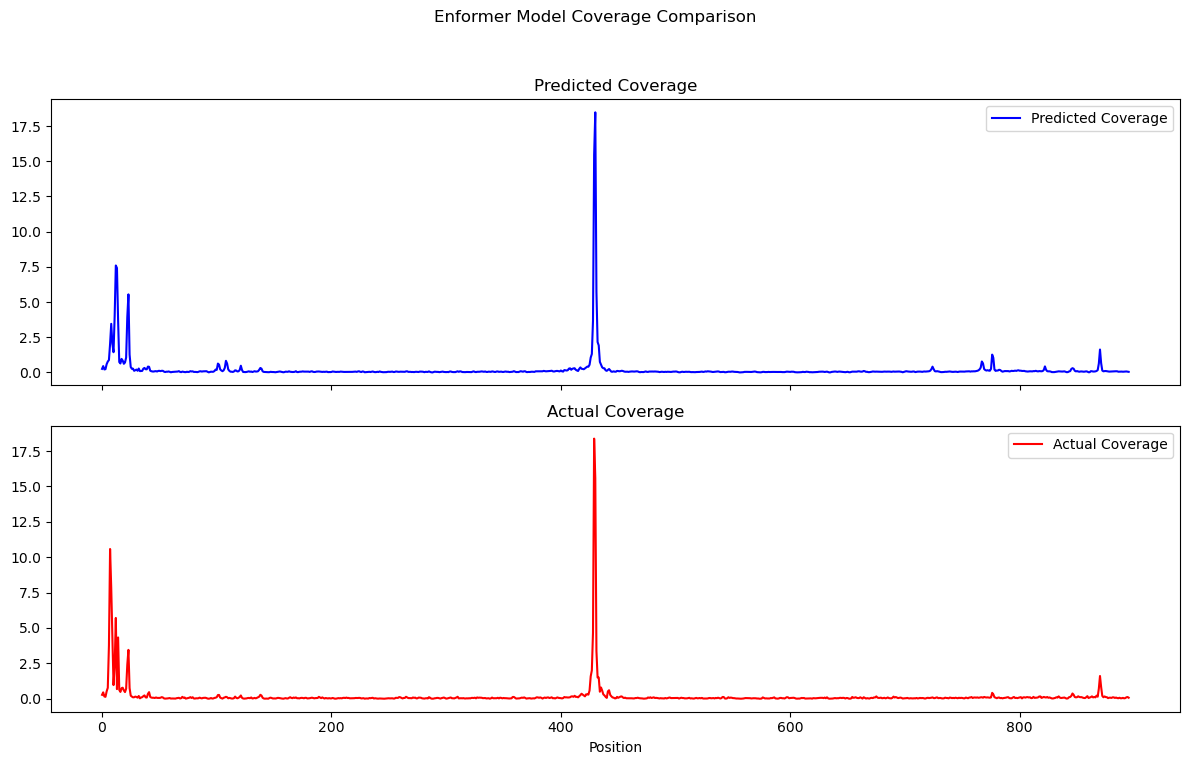

In [8]:
#now let's look at the sequence

import matplotlib.pyplot as plt

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the predicted coverage on the first subplot
ax1.plot(y_pred[:, 121].cpu(), label='Predicted Coverage', color='b')
ax1.set_title('Predicted Coverage')
ax1.legend()

# Plot the actual coverage on the second subplot
ax2.plot(targets[:, 121], label='Actual Coverage', color='r')
ax2.set_title('Actual Coverage')
ax2.legend()

# Add a shared x-axis label
ax2.set_xlabel('Position')

# Add a common y-axis label for both plots
# fig.text(0.04, 0.5, 'Coverage', va='center', rotation='vertical')

# Add a common title for both plots
fig.suptitle('Enformer Model Coverage Comparison')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()
